# <p style="text-align: center;"> Demo of GANs </p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing
import deepchem

from gandy.models import gans

In [2]:
deepchem.__version__

'2.5.0.dev'

# <p style="text-align: center;"> A regression task, using the boston dataset </p>

## <p style="text-align: center;"> Get Data </p>

In [3]:
# load data
Xs, Ys = sklearn.datasets.load_boston(return_X_y=True)
Xs_train, Xs_test, Ys_train, Ys_test = sklearn.model_selection.train_test_split(Xs, Ys, train_size = 0.8)

# normalize
x_norm = sklearn.preprocessing.Normalizer()
Xs_train = x_norm.fit_transform(Xs_train)
Xs_test = x_norm.transform(Xs_test)

# scale the ys
SCALING_FACTOR = np.max(Ys_train)
Ys_train = Ys_train/SCALING_FACTOR
Ys_test = Ys_test/SCALING_FACTOR

In [4]:
xshape = (Xs_train.shape[1],)  # remove zero dimension
print(xshape)
yshape = (1,)  # regression

(13,)


## <p style="text-align: center;"> Initialize Model </p>

###  <p style="text-align: center;">Hyperparam options! </p>

### Below are the defaults for

#### GAN stuff:
- ```n_classes=yshape[0]```
- ```noise_shape=(10,)```


### *ALL HYPERPARMS BELOW MUST START WITH*
```generator_``` or ```discriminator_```

#### Network architecture:

- ```layer_dimensions=[128]```
- ```dropout=0.05```


#### Layer kwargs:

- ```activation='relu'```
- ```use_bias=True```
- ```kernel_initializer="glorot_uniform"```
- ```bias_initializer="zeros"```
- ```kernel_regularizer='l2'```
- ```bias_regularizer=None```
- ```activity_regularizer=None```
- ```kernel_constraint=None```
- ```bias_constraint=None```


In [5]:
"""
Specifying n_classes yields a cGAN (contional GAN),
whereas a normal GAN is instanciated if n_classes is not specified.
For our uncertainty estimator, we always want a cGAN, so always set n_classes.
"""
# According the Lee and Seok, flip x and y:
# todo why specifying learning rate make non nan loss?
GAN = gans.GAN(xshape=yshape, yshape=xshape, n_classes=13, noise_shape=(5,), learning_rate=1e-4)

# A normal data generation call:
# GAN = gans.GAN(xshape=xshape, yshape=yshape, n_classes=1, noise_shape=(5,), learning_rate=1e-4)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\gandy\models\dcgan.py:96: UserWarning: Incorrect key learning_rate.                    Must start with generator_ or discriminator_
  Must start with generator_ or discriminator_")


## <p style="text-align: center;"> Train! </p>

###  <p style="text-align: center;">Hyperparam options</p>

#### Training:
- ```batches=50```

    (Number of batches of bootstrapped data, e.g., epochs, to train on)

In [6]:
# A normal data generation call:
# GAN.train(Xs_train, Ys_train, batches=50000)

# Flipping x and y:
GAN.train(Ys_train, Xs_train, batches=50000)

Ending global_step 999: generator average loss 0.69536, discriminator average loss 1.38287
Ending global_step 1999: generator average loss 0.696301, discriminator average loss 1.38107
Ending global_step 2999: generator average loss 0.700762, discriminator average loss 1.37573
Ending global_step 3999: generator average loss 0.70827, discriminator average loss 1.37029
Ending global_step 4999: generator average loss 0.718148, discriminator average loss 1.36587
Ending global_step 5999: generator average loss 0.731029, discriminator average loss 1.36072
Ending global_step 6999: generator average loss 0.744675, discriminator average loss 1.35707
Ending global_step 7999: generator average loss 0.760214, discriminator average loss 1.35337
Ending global_step 8999: generator average loss 0.779749, discriminator average loss 1.35111
Ending global_step 9999: generator average loss 0.792294, discriminator average loss 1.34851
Ending global_step 10999: generator average loss 0.80483, discriminator a

In [7]:
GAN._model.batch_size # this is automaticaally baked into deepchem

100

## <p style="text-align: center;"> Predict </p>

###  <p style="text-align: center;">Hyperparam options</p>

#### Prediction:
- ```num_predictions=100```

    (Number of predictions to make in order to sample uncertainties.)

In [8]:
# Because this is a conditional GAN, MUST specify Ys or a warning will be thrown

# A normal data generation call:
# preds, uncs, flags = GAN.predict(Xs_test, uc_threshold = 0.01, Ys=Ys_test)

# Flipping x and y:
# preds, uncs, flags = GAN.predict(Ys_test, uc_threshold = 0.01, Ys=Xs_test)

## <p style="text-align: center;"> Results </p>

In [21]:
preds, uncs = GAN._predict(Ys_test, Xs_test, num_predictions=500)
thresh = 0.02
flags = uncs > thresh
print(np.average(uncs))

0.015745554


Text(0.5, 1.0, 'Certain and uncertain predictions, boston data')

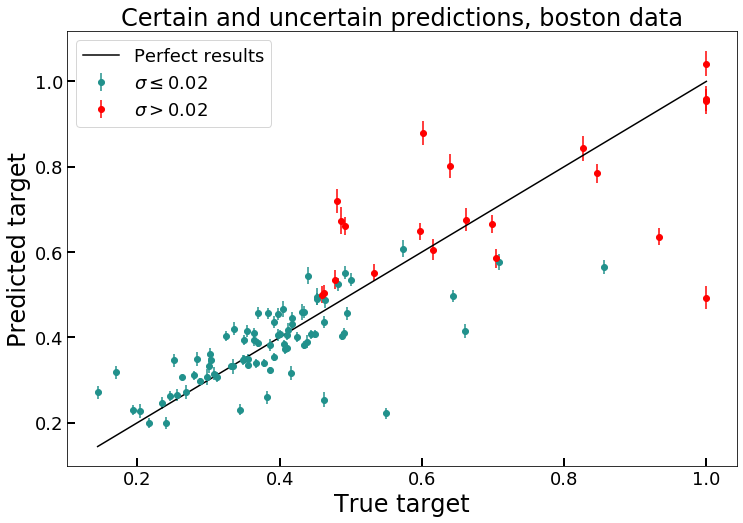

In [22]:
# figure
fig, ax = plt.subplots(figsize=(12,8))

# plotting predicted vs true
# scatter
ax.errorbar(Ys_test.reshape(-1,1)[flags == False],
           preds[flags == False], yerr = uncs[flags == False], ls='none',
           c=plt.cm.viridis(0.5), marker='o', label=f'$\sigma \leq {thresh}$')
ax.errorbar(Ys_test.reshape(-1,1)[flags == True],
           preds[flags == True], yerr = uncs[flags == True], ls='none',
           c='r', marker='o', label=f'$\sigma > {thresh}$')
min_y, max_y = np.min(Ys_test.reshape(-1,1)), np.max(Ys_test.reshape(-1,1))
# perfect results
x = np.linspace(min_y, max_y, 100)
ax.plot(x, x, 'k-', label= "Perfect results")

# axes labels formatting
ax.set_xlabel('True target', fontsize=24)
ax.set_ylabel('Predicted target', fontsize=24)

# tick formatting
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

# legend & title
plt.legend(fontsize=18)
plt.title('Certain and uncertain predictions, boston data', size=24)